<a href="https://colab.research.google.com/github/rickiepark/llm-from-scratch/blob/main/ch04/01_main-chapter-code/ch04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
세바스찬 라시카(Sebastian Raschka)가 쓴 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>의 번역서 <br><<b><a href="<a href="http://tensorflow.blog/llm-from-scratch">밑바닥부터 만들면서 배우는 LLM</a></b>>의 예제 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rickiepark/llm-from-scratch">https://github.com/rickiepark/llm-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://tensorflow.blog/llm-from-scratch"><img src="https://tensorflowkorea.wordpress.com/wp-content/uploads/2025/09/ebb091ebb094eb8ba5llm_ebb3b8ecb185_ec959eeba9b4.jpg" width="100px"></a>
</td>
</tr>
</table>


# 4장: 밑바닥부터 GPT 모델 구현하기

In [33]:
from importlib.metadata import version

print("맷플롯립 버전:", version("matplotlib"))
print("파이토치 버전:", version("torch"))
print("tiktoken 버전:", version("tiktoken"))

맷플롯립 버전: 3.10.8
파이토치 버전: 2.8.0
tiktoken 버전: 0.12.0


- 이 장에서 GPT와 유사한 LLM 구조를 구현합니다. 다음 장에서는 이 LLM 훈련하는데 초점을 맞추겠습니다.

<img src="images/llm_from_scratch/ch04_compressed/01.webp" width="800px">

## 4.1 구조 구현하기

- 1장은 GPT와 Llama 같은 모델을 소개했습니다. 이런 모델은 원본 트랜스포머 구조의 디코더 부분을 기반으로 순차적으로 단어를 생성합니다.
- 따라서 이런 LLM을 종종 디코더 기반 LLM이라 부릅니다.
- 전통적인 딥러닝 모델과 비교하면 LLM은 규모가 큽니다. 이는 코드의 양이 아니라 방대한 파라미터 개수 때문입니다.
- 앞으로 보겠지만 LLM 구조의 많은 구성 요소가 반복적입니다.

<img src="images/llm_from_scratch/ch04_compressed/02.webp" width="600px">

- 이전 장에서 설명의 편의를 위해 토큰 입력과 출력의 임베딩 차원을 작게 했습니다.
- 이 장에서는 작은 GPT-2 모델와 같은 임베딩 크기를 사용합니다.
- 구체적으로 Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)에 나온 가장 작은 GPT-2 모델 구조(1억 2,400만 파라미터)를 구현하겠습니다(처음에는 1억 1,700만 파라미터라고 보고되었지만 나중에 모델 저장소에 수정된 값으로 공개되었습니다).
- 여기서 구현한 모델은 3억 4,500만 파라미터, 7억 6,200만 파라미터, 15억 4,200만 파라미터를 가진 모델과 호환됩니다. 5장에서 이 구현에 사전 훈련된 가중치를 로드하는 방법을 알아 보겠습니다.

- 1억 2,400만 파라미터 GPT-2 모델의 설정은 다음과 같습니다:

In [34]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 어휘사전 크기
    "context_length": 1024, # 문맥 길이
    "emb_dim": 768,         # 임베딩 차원
    "n_heads": 12,          # 어텐션 헤드 개수
    "n_layers": 12,         # 층 개수
    "drop_rate": 0.1,       # 드롭아웃 비율
    "qkv_bias": False       # 쿼리, 키, 값을 만들 때 편향 포함 여부
}

- `"vocab_size"`는 BPE 토크나이저(2장 참조)에서 사용할 50,257 토큰으로 구성된 어휘 사전 크기를 나타냅니다.
- `"context_length"`는 위치 임베딩(2장 참조)으로 모델이 다룰 수 있는 입력 토큰의 최대 개수입니다.
- `"emb_dim"`은 임베딩 크기를 나타내며, 각 토큰을 768 차원의 벡터로 변환합니다.
- `"n_heads"`는 멀티 헤드 어텐션 메커니즘(3장 참조)에 있는 어텐션 헤드의 개수입니다.
- `"n_layers"`에는 모델에 있는 (이 장에서 소개할) 트랜스포머 블록의 개수를 지정합니다.
- `"drop_rate"`는 과대적합을 막기 위한 드롭아웃 메커니즘(3장 참조)의 강도를 지정합니다(0.1은 은닉 유닛의 10%를 랜덤하게 제외한다는 의미입니다).
- `"qkv_bias"`는 멀티 헤드 어텐션의 Linear 층에서 쿼리, 키, 값을 계산할 때 편향 유닛을 도입할지 여부를 결정합니다. 현대적인 LLM의 구성 방식을 따라서 처음에는 이 값을 비활성화하지만 오픈AI의 사전 훈련된 GPT-2 가중치를 모델로 로드할 때 이를 다시 살펴 보겠습니다(5장 참조).

<img src="images/llm_from_scratch/ch04_compressed/03.webp" width="800px">

In [35]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    """
    GPT 모델의 전체 구조를 정의하는 클래스입니다.
    실제 연산(Attention 등)은 제외하고, 데이터의 흐름과 입출력 차원을 맞추는 구조만 구현되어 있습니다.
    """
    def __init__(self, cfg):
        super().__init__()
        
        # 1. 토큰 임베딩 (Token Embedding)
        # 입력된 단어 ID(정수)를 벡터(실수)로 변환합니다.
        # 크기: [vocab_size, emb_dim] (예: 50257개 단어, 768차원)
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        
        # 2. 위치 임베딩 (Position Embedding)
        # Transformer는 순서 정보가 없으므로, 단어의 위치 정보를 벡터로 학습하여 더해줍니다.
        # 크기: [context_length, emb_dim] (예: 최대 1024개 위치, 768차원)
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        
        # 3. 드롭아웃 (Dropout)
        # 과적합(Overfitting)을 방지하기 위해 임베딩 값의 일부를 무작위로 0으로 만듭니다.
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # 4. 트랜스포머 블록 (Transformer Blocks)
        # 실제 GPT의 핵심 연산(Self-Attention + Feed Forward)이 일어나는 층을 여러 개 쌓습니다.
        # 여기서는 더미(Dummy) 블록을 사용하여 구조만 잡았습니다.
        # * (Asterisk)는 리스트의 요소를 풀어서(unpacking) 인자로 전달합니다.
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # 5. 최종 정규화 (Final LayerNorm)
        # 블록들을 통과한 후, 데이터 분포를 안정화하기 위한 정규화 층입니다.
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        
        # 6. 출력 헤드 (Output Head)
        # 최종 벡터를 다시 단어 집합 크기(vocab_size)로 변환하여,
        # 다음에 올 단어의 확률(Logits)을 계산합니다.
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        # in_idx: 입력 데이터 (배치 크기, 시퀀스 길이) -> 예: [Batch, Seq_Len]
        batch_size, seq_len = in_idx.shape
        
        # A. 토큰 임베딩 변환
        # 입력: [Batch, Seq_Len] -> 출력: [Batch, Seq_Len, Emb_Dim]
        tok_embeds = self.tok_emb(in_idx)
        
        # B. 위치 임베딩 생성
        # 0부터 seq_len-1까지의 숫자를 생성하여 위치 벡터로 변환합니다.
        # device=in_idx.device는 입력 데이터와 같은 장치(CPU/GPU)를 쓰기 위함입니다.
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        # C. 임베딩 합산 (Input Embedding)
        # 토큰 정보와 위치 정보를 더해줍니다. (브로드캐스팅에 의해 배치 내 모든 샘플에 동일하게 더해짐)
        x = tok_embeds + pos_embeds
        
        # D. 드롭아웃 적용
        x = self.drop_emb(x)
        
        # E. 트랜스포머 블록 통과
        # 여러 층의 블록을 순차적으로 통과하며 특징을 추출합니다.
        x = self.trf_blocks(x)
        
        # F. 최종 정규화
        x = self.final_norm(x)
        
        # G. 다음 단어 예측 (Logits 산출)
        # 출력: [Batch, Seq_Len, Vocab_Size]
        logits = self.out_head(x)
        
        return logits


class DummyTransformerBlock(nn.Module):
    """
    실제로는 Multi-Head Attention과 FeedForward Network가 들어가는 곳입니다.
    구조 파악을 위해 입력을 그대로 반환하는 더미 클래스로 대체되었습니다.
    """
    def __init__(self, cfg):
        super().__init__()
        # 실제 구현에서는 여기에 Attention, MLP, LayerNorm 등이 정의됩니다.

    def forward(self, x):
        # 아무런 연산도 수행하지 않고 입력을 그대로 다음 층으로 넘깁니다.
        return x


class DummyLayerNorm(nn.Module):
    """
    Layer Normalization을 흉내 내는 더미 클래스입니다.
    실제로는 평균과 분산을 이용해 데이터를 정규화합니다.
    """
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 실제 LayerNorm과 인터페이스(파라미터 입력 방식)를 맞추기 위한 초기화입니다.

    def forward(self, x):
        # 아무런 연산도 수행하지 않고 입력을 그대로 반환합니다.
        return x

<img src="images/llm_from_scratch/ch04_compressed/04.webp" width="650px">

In [36]:
import torch  # PyTorch 라이브러리 (텐서 연산을 위해 필요)
import tiktoken  # OpenAI의 BPE 토크나이저 라이브러리

# 1. 토크나이저 초기화
# GPT-2 모델이 사용하는 인코딩 방식('gpt2')을 로드합니다.
tokenizer = tiktoken.get_encoding("gpt2")

# 데이터를 모을 빈 리스트 생성
batch = []

# 2. 예제 데이터 준비
# 처리할 문장 두 개를 정의합니다.
# 주의: torch.stack을 사용하려면 두 문장의 토큰 길이가 같아야 합니다.
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

# 3. 인코딩 및 텐서 변환
# 과정: 텍스트 -> 토큰 ID 리스트(encode) -> 파이토치 텐서(tensor) -> 리스트에 추가(append)
# txt1을 토큰화하여 텐서로 변환 후 batch 리스트에 담습니다.
batch.append(torch.tensor(tokenizer.encode(txt1)))

# txt2도 동일하게 처리하여 batch 리스트에 담습니다.
batch.append(torch.tensor(tokenizer.encode(txt2)))

# 4. 배치 생성 (Stacking)
# 현재 batch는 [tensor([..]), tensor([..])] 형태의 리스트입니다.
# 이를 하나의 큰 텐서(행렬)로 합칩니다. dim=0은 세로 방향(행)으로 쌓겠다는 의미입니다.
# 결과 Shape 예상: [2, 4] (2개의 문장, 각 문장은 4개의 토큰)
batch = torch.stack(batch, dim=0)

# 결과 출력
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [37]:
import torch

# 1. 랜덤 시드 고정
# 실행할 때마다 결과가 달라지지 않도록 난수 생성기의 초기값을 '123'으로 고정합니다.
# (디버깅이나 학습용 예제에서 결과를 재현하기 위해 필수적입니다.)
torch.manual_seed(123)

# 2. 모델 인스턴스 생성
# GPT-2(124M 버전)의 설정값(GPT_CONFIG_124M)을 사용하여 모델을 만듭니다.
# 'Dummy'라는 이름에서 알 수 있듯이, 아직 학습되지 않은(랜덤 가중치를 가진) 껍데기 모델일 가능성이 높습니다.
model = DummyGPTModel(GPT_CONFIG_124M)

# 3. 순전파 (Forward Pass) 실행
# 앞서 만든 데이터(batch)를 모델에 통과시켜 예측값을 계산합니다.
# 반환된 'logits'는 확률로 변환되기 전의 원시 점수(Score)입니다.
logits = model(batch)

# 4. 결과 확인
# 출력 텐서의 형태(Shape)를 확인합니다.
# 예상 형태: [배치 크기, 문장 길이, 단어 사전 크기] -> 예: [2, 4, 50257]
print("출력 크기:", logits.shape)

# 실제 계산된 텐서 값들을 출력합니다.
print(logits)

출력 크기: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 층 정규화로 활성화 정규화하기

- LayerNorm([Ba et al. 2016](https://arxiv.org/abs/1607.06450))이라고도 불리는 층 정규화는 신경망 층의 활성화를 평균이 0이고 분산이 1이 되도록 조정합니다.
- 이를 통해 훈련을 안정화하고 가중치 수렴 속도를 높일 수 있습니다.
- 나중에 구현하겠지만 층 정규화는 트랜스포머 블록의 멀티 헤드 어텐션 모듈 전후에 적용됩니다. 또한 최종 출력 층 전에도 적용됩니다.

<img src="images/llm_from_scratch/ch04_compressed/05.webp" width="600px">

- 작은 입력 샘플을 간단한 신경망 층에 통과시켜 층 정규화의 작동 방식을 알아 보죠:

In [38]:
import torch
import torch.nn as nn

# 1. 랜덤 시드 고정
# 매번 실행할 때마다 같은 랜덤 값이 나오도록 설정하여 결과를 재현할 수 있게 합니다.
torch.manual_seed(123)

# 2. 입력 데이터(Batch) 생성
# 형태(Shape): [2, 5] -> (배치 크기=2, 입력 특징의 개수=5)
# 예: 5가지 속성을 가진 데이터 샘플이 2개 있다는 의미입니다.
batch_example = torch.randn(2, 5) 

# 3. 신경망 층(Layer) 정의
# nn.Sequential은 여러 모듈을 순서대로 묶어주는 컨테이너입니다.
layer = nn.Sequential(
    # (1) 선형 변환 (Linear Layer): 
    # 입력 차원 5개를 받아 -> 6개의 차원으로 확장/변환합니다.
    # 내부 연산: Output = Input x Weight + Bias
    nn.Linear(5, 6), 
    
    # (2) 활성화 함수 (ReLU):
    # 선형 변환된 값에서 음수는 0으로 만들고, 양수는 그대로 둡니다.
    # 비선형성을 추가하여 모델이 복잡한 패턴을 학습할 수 있게 돕습니다.
    nn.ReLU()
)

# 4. 순전파 (Forward Pass)
# 데이터를 층에 통과시킵니다.
# 입력 [2, 5] -> Linear 거침 -> [2, 6] -> ReLU 거침 -> 최종 [2, 6]
out = layer(batch_example)

# 5. 결과 출력
# 결과 형태는 [2, 6]이 됩니다. (2개의 샘플, 각 샘플당 6개의 특징값)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 두 개의 입력에 대해 각각 평균과 분산을 계산해 보겠습니다:

In [39]:
# 1. 평균(Mean) 계산
# dim=-1: 가장 마지막 차원(여기서는 6개의 특성 값)을 기준으로 평균을 냅니다.
#         즉, "각 샘플(행)마다" 가지고 있는 6개 숫자의 평균을 구합니다.
# keepdim=True: 계산 후 차원을 없애지 않고 유지합니다.
#               입력 [2, 6] -> 결과 [2, 1] (이 옵션이 없으면 [2]가 됨)
mean = out.mean(dim=-1, keepdim=True)

# 2. 분산(Variance) 계산
# 데이터가 평균으로부터 얼마나 퍼져있는지(변동성)를 계산합니다.
# 옵션은 평균 계산과 동일하게 마지막 차원을 기준으로 차원을 유지하며 계산합니다.
var = out.var(dim=-1, keepdim=True)

# 결과 출력
print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
분산:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 정규화는 두 입력(행)에 대해 독립적으로 적용됩니다. dim=-1을 사용하면 행 차원이 아니라 마지막 차원(이 경우 특성 차원)을 따라 계산이 수행됩니다.

<img src="images/llm_from_scratch/ch04_compressed/06.webp" width="600px">

- 평균을 빼고, 분산의 제곱근(표준편차)으로 나누면 입력을 열(특성) 차원을 따라 평균이 0이고 분산이 1이 되도록 만듭니다:

In [40]:
# 1. 정규화 (Normalization) 수행
# 공식: (입력값 - 평균) / 표준편차
# torch.sqrt(var)는 분산의 제곱근이므로 '표준편차'가 됩니다.
# 이 과정을 거치면 데이터의 중심이 0으로 이동하고, 퍼짐 정도가 1로 맞춰집니다.
out_norm = (out - mean) / torch.sqrt(var)

print("정규화된 층 출력:\n", out_norm)

# 2. 결과 검증 (Verification)
# 정규화가 제대로 되었다면,
# 다시 구한 평균은 0에 매우 가깝고, 분산은 1에 매우 가까워야 합니다.
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

# 3. 검증 결과 출력
# e-08 등의 표현이 나온다면 0에 아주 가까운 숫자라는 뜻입니다. (부동소수점 오차 감안)
print("평균 (0에 가까워야 함):\n", mean)
print("분산 (1에 가까워야 함):\n", var)

정규화된 층 출력:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
평균 (0에 가까워야 함):
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
분산 (1에 가까워야 함):
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 각 입력의 평균은 0이고 분산은 1입니다. 결과를 보기 쉽도록 파이토치의 과학적 표기법을 끌 수 있습니다:

In [41]:
torch.set_printoptions(sci_mode=False)
print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 위에서 각 입력의 특성을 정규화했습니다.
- 이제 동일한 아이디어를 사용해 `LayerNorm` 클래스를 구현해 보죠:

In [42]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # 1. 엡실론 (Epsilon) 정의
        # 분산이 0이 되어 나눗셈 에러(Division by Zero)가 발생하는 것을 막기 위한 아주 작은 수입니다.
        self.eps = 1e-5
        
        # 2. 학습 가능한 파라미터 (Scale & Shift)
        # 단순히 정규화만 하면 모델의 표현력이 제한될 수 있습니다.
        # 모델이 필요에 따라 데이터의 분포를 다시 조정할 수 있도록 '가중치'를 줍니다.
        
        # Scale (Gamma): 1로 초기화 (곱해도 값 변화 없음)
        # nn.Parameter로 감싸야 역전파(Backprop) 때 학습(업데이트)이 됩니다.
        self.scale = nn.Parameter(torch.ones(emb_dim))
        
        # Shift (Beta): 0으로 초기화 (더해도 값 변화 없음)
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        # 3. 통계량 계산
        # 입력 데이터(x)의 마지막 차원(특성)을 기준으로 평균을 구합니다.
        mean = x.mean(dim=-1, keepdim=True)
        
        # 분산을 구합니다.
        # unbiased=False: 표본 분산(n-1로 나눔)이 아닌 모분산(n으로 나눔) 공식을 사용합니다.
        # (딥러닝에서는 보통 n으로 나누는 방식을 선호합니다)
        var = x.var(dim=-1, keepdim=True, unbiased=False) 
        
        # 4. 정규화 (Normalization)
        # (입력 - 평균) / sqrt(분산 + 엡실론)
        # 데이터의 평균을 0, 분산을 1로 맞춥니다.
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        
        # 5. 아핀 변환 (Affine Transformation)
        # 정규화된 값에 학습된 스케일을 곱하고 시프트를 더해 최종 출력을 만듭니다.
        # 이를 통해 모델은 정규화된 상태를 유지할지, 원래 데이터 특성을 살릴지 스스로 학습합니다.
        return self.scale * norm_x + self.shift

**스케일 조정과 이동**

- 평균을 빼고, 분산으로 나누어 정규화하는 것 이외에 두 개의 훈련 가능한 파라미터 `scale`과 `shift`를 추가했습니다.
- 초기 `scale`(1)과 `shift`(0)은 아무런 영향을 미치지 못합니다. 하지만 `scale`과 `shift`가 훈련 가능한 파라미터이기 때문에 훈련 과정에서 두 파라미터를 조정하는 것이 훈련 작업에서 모델의 성능을 향상시킨다고 판단하는 경우 LLM이 자동으로 조정합니다.
- 이를 통해 모델은 처리하는 데이터에 가잘 잘 맞는 스케일 조정과 이동을 학습할 수 있습니다.
- 분산의 제곱근을 계산할 때 작은 값(`eps`)를 더합니다. 이는 분산이 0일 경우 0 나눗셈 오류를 방지하기 위해서입니다.

**편향된 분산**
- 위 분산 계산에서 `unbiased=False`는 $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 식으로 분산을 계산한다는 의미입니다. `n`은 샘플 크기입니다(여기서는 특성 또는 열 개수). 이 공식은 (분모가 `n-1`인) 베셀 보정(Bessel's correction)을 사용하지 않습니다. 따라서 편향된 분산을 추정합니다.
- LLM에서 임베딩 차원 `n`은 매우 크므로 `n`과 `n-1`을 사용하는 차이는 무시할 수 있습니다.
- 하지만 GPT-2가 정규화 층에 편향된 분산을 사용했으므로 나중에 사전 훈련된 가중치를 로드할 때 호환성을 위해 동일한 방식을 적용했습니다.
- 이제 `LayerNorm`을 실제로 테스트해 보죠:

In [43]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [44]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="images/llm_from_scratch/ch04_compressed/07.webp" width="700px">

## 4.3 GELU 활성화 함수를 사용하는 피드 포워드 네트워크 구현하기

- 이 절에서 LLM의 트랜스포머 블록에서 사용되는 작은 신경망 모듈을 구현합니다.
- 딥러닝에서는 ReLU(Rectified Linear Unit) 활성화 함수가 간단하며 다양한 신경망 구조에서 효과적이기 때문에 널리 사용됩니다.
- LLM에서는 전통적인 ReLU 외에도 다양한 종류의 활성화 함수가 사용됩니다. 대표적인 두 개의 함수는 GELU(Gaussian Error Linear Unit)와 SwiGLU(Swish-Gated Linear Unit)입니다.
- GELU와 SwiGLU는 각각 가우스 오차 함수와 시그모이드 GLU(gated linear unit)을 사용한 더 복잡하고 부드러운 활성화 함수입니다. 간단한 ReLU와 달리 딥러닝 모델의 성능을 향상시킵니다.

- GELU 활성화 함수([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415))는 여러 방법으로 구현할 수 있습니다. 정확한 정의는 GELU(x) = x⋅𝛷(x)입니다. 여기서 𝛷(x)는 표준 가우스 누적 분포 함수(가우스 오차 함수)입니다.
- 실제로는 계산하기 쉬운 근사식으로 구현합니다: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (원본 GPT-2 모델도 커브 피팅(curve fitting)으로 찾은 이 근사식을 사용했습니다).

In [45]:
import torch
import torch.nn as nn

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        # GELU는 학습해야 할 가중치(Parameter)가 없는 수학적 함수입니다.
        # 따라서 초기화 함수(__init__)에서는 별다른 설정이 필요 없습니다.

    def forward(self, x):
        # GELU의 'tanh 근사 공식' 구현
        # 원래 공식은 정규분포의 누적분포함수(CDF)를 사용하지만 계산 비용이 비쌉니다.
        # 따라서 아래와 같이 tanh를 사용한 근사식을 주로 사용합니다.
        # 식: 0.5 * x * (1 + tanh( sqrt(2/pi) * (x + 0.044715 * x^3) ))
        
        return 0.5 * x * (1 + torch.tanh(
            # sqrt(2/pi)는 약 0.7978 정도 되는 상수입니다.
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * # 0.044715는 근사 오차를 최소화하기 위해 수학적으로 유도된 계수입니다.
            (x + 0.044715 * torch.pow(x, 3))
        ))

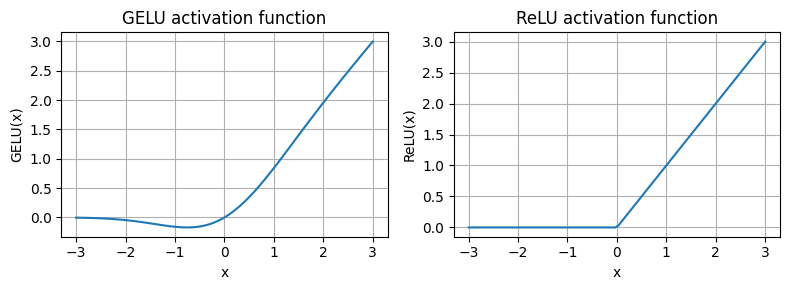

In [46]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# 샘플 데이터
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 여기서 보듯이 ReLU는 양수는 그대로 출력하고 음수는 모두 0을 출력하는 구간별 선형 함수(piecewise linear function)입니다.
- GELU는 부드러운 비선형 함수로, ReLU와 비슷하지만 모든 음수 값의 그레이디언트를 0으로 만들지 않습니다(대략 x = -0.75에서는 그레이디언트가 0이 됩니다).
- 그다음 LLM의 트랜스포머 블록에 사용할 작은 신경망 모듈인 `FeedForward`를 구현해 보죠:

In [47]:
import torch.nn as nn

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        # nn.Sequential: 여러 층(Layer)을 순서대로 묶어서 실행하는 컨테이너입니다.
        self.layers = nn.Sequential(
            
            # 1. 확장 단계 (Expansion)
            # 입력 차원(emb_dim)을 4배로 뻥튀기합니다.
            # 예: 768 -> 3072 (GPT-2 small 기준)
            # 이유: 차원을 넓혀서 더 풍부하고 복잡한 특징을 학습하기 위함입니다.
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            
            # 2. 활성화 함수 (GELU)
            # 앞서 구현한 GELU 함수를 사용하여 비선형성을 추가합니다.
            # 0보다 작은 값을 부드럽게 처리하여 학습 안정성을 높입니다.
            GELU(),
            
            # 3. 압축/복원 단계 (Projection)
            # 4배로 늘어났던 차원을 다시 원래 크기(emb_dim)로 줄입니다.
            # 예: 3072 -> 768
            # 이유: 다음 레이어나 블록으로 데이터를 넘겨주기 위해 입출력 크기를 맞춰야 합니다.
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        # 정의된 순서대로(Linear -> GELU -> Linear) 데이터를 통과시킵니다.
        # 입력 x와 출력의 형태(Shape)는 동일하게 유지됩니다. (배치, 시퀀스, 임베딩 차원)
        return self.layers(x)

In [48]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="images/llm_from_scratch/ch04_compressed/09.webp" width="600px">

In [49]:
ffn = FeedForward(GPT_CONFIG_124M)

# 입력 크기: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


입력에서 필요한 정보를 추출할 때 좀 더 잘 추출하기 위해 뻥튀기를 함

<img src="images/llm_from_scratch/ch04_compressed/10.webp" width="600px">

<img src="images/llm_from_scratch/ch04_compressed/11.webp" width="600px">

## 4.4 숏컷 연결 추가하기

- 스킵 연결(skip connection)이나 잔차 연결(residual connection)이라고도 부르는 숏컷 연결(shortcut connection) 이면의 개념을 알아 보죠.
- 원래 숏컷 연결은 컴퓨터 비전 분야의 심층 신경망(구체적으로 잔차 신경망(residual network))에서 그레이디언트 소실 문제를 완화하기 위해 제안되었습니다.
- 숏컷 연결이 그레이디언트가 한 개 이상의 층을 건너 뛰어 네트워크에 흐를 수 있도록 짧은 다른 경로를 만든다는 것을 보여줍니다.
- 이런 경로는 한 층의 출력을 이후 층의 출력에 더하여 만들어집니다.
- 작은 샘플 네트워크로 이 아이디어를 설명해 보죠:

<img src="images/llm_from_scratch/ch04_compressed/12.webp" width="600px">

- 코드로 구현하면 다음과 같습니다:

In [50]:
import torch
import torch.nn as nn

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        
        # 1. 층(Layer) 생성
        # nn.ModuleList를 사용하여 5개의 층을 리스트 형태로 관리합니다.
        # 각 층은 [선형 변환 -> GELU 활성화 함수]로 구성됩니다.
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        # 2. 순전파 (Forward Pass)
        for layer in self.layers:
            # 현재 층을 통과시켜 출력을 계산합니다. (F(x))
            layer_output = layer(x)
            
            # 3. 스킵 연결 (Skip Connection / Residual Connection) 적용 로직
            # 조건 1: use_shortcut이 True여야 함 (사용자가 원할 때)
            # 조건 2: 입력(x)과 출력(layer_output)의 차원(Shape)이 같아야 더할 수 있음
            if self.use_shortcut and x.shape == layer_output.shape:
                # [핵심] 입력값 x를 출력값에 그대로 더해줍니다. (x + F(x))
                # 이렇게 하면 역전파 때 그레이디언트가 이 '지름길'을 타고
                # 입력 쪽으로 막힘없이 흐를 수 있습니다.
                x = x + layer_output
            else:
                # 스킵 연결을 안 쓰거나 차원이 다르면, 그냥 층의 출력만 다음으로 넘깁니다.
                x = layer_output
        return x


def print_gradients(model, x):
    # 1. 정방향 계산
    output = model(x)
    target = torch.tensor([[0.]]) # 임의의 정답지 (Loss 계산용)

    # 2. 손실(Loss) 계산
    # 모델의 출력과 목표값(0) 사이의 오차를 계산합니다. (MSE)
    loss = nn.MSELoss()
    loss = loss(output, target)

    # 3. 역전파 (Backpropagation)
    # 오차를 줄이기 위해 각 가중치를 얼마나 수정해야 할지(기울기) 계산합니다.
    # 이때 미분값이 뒤에서부터 앞으로 흘러옵니다.
    loss.backward()

    # 4. 그레이디언트(기울기) 확인
    # 각 층의 가중치(weight)들이 가진 기울기의 크기를 출력합니다.
    # 층이 깊어질수록 이 값이 0에 가까워지는지(소실 문제) 확인하는 것이 목적입니다.
    for name, param in model.named_parameters():
        if 'weight' in name:
            # param.grad: 계산된 기울기
            # abs().mean(): 기울기들의 절댓값 평균 (방향 무시하고 크기만 봄)
            print(f"{name}의 평균 그레이디언트는 {param.grad.abs().mean().item()}입니다.")

- 숏컷 연결이 **없을** 때 그레디언트 값을 출력해 보죠:

In [51]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight의 평균 그레이디언트는 0.00020173587836325169입니다.
layers.1.0.weight의 평균 그레이디언트는 0.0001201116101583466입니다.
layers.2.0.weight의 평균 그레이디언트는 0.0007152041071094573입니다.
layers.3.0.weight의 평균 그레이디언트는 0.0013988735154271126입니다.
layers.4.0.weight의 평균 그레이디언트는 0.005049645435065031입니다.


- 그다음 숏컷 연결이 **있을** 때 그레이디언트 값을 출력합니다:

In [52]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight의 평균 그레이디언트는 0.22169791162014008입니다.
layers.1.0.weight의 평균 그레이디언트는 0.20694106817245483입니다.
layers.2.0.weight의 평균 그레이디언트는 0.32896995544433594입니다.
layers.3.0.weight의 평균 그레이디언트는 0.2665732204914093입니다.
layers.4.0.weight의 평균 그레이디언트는 1.3258540630340576입니다.


- 위 출력에서 볼 수 있듯이 숏컷 연결이 앞쪽 층(`layer.0` 층)의 그레이디언트 소실 문제를 막습습니다.
- 숏컷 연결의 개념을 사용해 트랜스포머 블록을 구현하겠습니다.

## 4.5 어텐션과 선형 층을 트랜스포머 블록에 연결하기

- 이 절에서 이전에 배운 개념을 소위 트랜스포머 블록에 결합합니다.
- 트랜스포머 블록은 이전 층에서 다룬 코잘 멀티 헤드 어텐션 모듈과 앞서 다룬 피드 포워드 신경망을 결합합니다.
- 또한 트랜스포머 블록은 드롭아웃과 숏컷 연결을 사용합니다.


In [53]:
from previous_chapters import MultiHeadAttention
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        # 1. 멀티 헤드 어텐션 (Multi-Head Attention)
        # 문맥을 파악하는 핵심 부품입니다.
        # "단어들 사이의 관계"를 계산하여 문맥 정보를 수집합니다.
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        
        # 2. 피드 포워드 신경망 (FeedForward)
        # 수집된 문맥 정보를 바탕으로 각 토큰(단어)의 정보를 개별적으로 가공/확장합니다.
        self.ff = FeedForward(cfg)
        
        # 3. 레이어 정규화 (LayerNorm)
        # 학습을 안정적으로 만들기 위해 데이터 분포를 정리합니다.
        # 어텐션 앞(norm1)과 피드포워드 앞(norm2)에 각각 하나씩 배치됩니다.
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        
        # 4. 드롭아웃 (Dropout)
        # 과적합(Overfitting)을 방지하기 위해 숏컷 연결 직전에 사용합니다.
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # === [파트 1] 어텐션 블록 (Attention Block) ===
        
        # A. 숏컷(Shortcut) 저장
        # "변형되기 전의 원본 데이터"를 따로 빼둡니다. (잔차 연결용)
        shortcut = x
        
        # B. 정규화 (Pre-LayerNorm)
        # 어텐션에 들어가기 '전에' 정규화를 먼저 합니다. (GPT-2 방식)
        x = self.norm1(x)
        
        # C. 어텐션 수행
        # 자기 자신을 포함한 주변 단어들의 정보를 모읍니다.
        # 크기 유지: [batch_size, num_tokens, emb_size]
        x = self.att(x)
        
        # D. 드롭아웃 적용
        x = self.drop_shortcut(x)
        
        # E. 잔차 연결 (Residual Connection)
        # "학습된 변화량(x)"에 "원본(shortcut)"을 더합니다.
        # 이는 정보가 손실되지 않고 깊은 층까지 흐르게 도와줍니다.
        x = x + shortcut 

        # === [파트 2] 피드 포워드 블록 (Feed Forward Block) ===
        
        # A. 숏컷 저장 (현재 상태를 다시 원본으로 취급)
        shortcut = x
        
        # B. 정규화
        x = self.norm2(x)
        
        # C. 피드 포워드 수행
        # 정보를 확장했다가 압축하며 특징을 학습합니다.
        x = self.ff(x)
        
        # D. 드롭아웃
        x = self.drop_shortcut(x)
        
        # E. 잔차 연결
        x = x + shortcut 

        return x

<img src="images/llm_from_scratch/ch04_compressed/13.webp" width="600px">

- 두 개의 입력 샘플이 있다고 가정해 보죠. 각 샘플은 여섯 개의 토큰으로 구성되고 각 토큰은 768차원의 임베딩 벡터입니다. 트랜스포머 블록이 셀프 어텐션과 피드 포워드 신경망을 적용하여 동일 크기의 출력을 반환합니다.
- 이 출력을 이전 장에서 이야기한 문맥 벡터의 증강된 버전으로 생각할 수 있습니다.

In [54]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # 크기: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("입력 크기:", x.shape)
print("출력 크기:", output.shape)

입력 크기: torch.Size([2, 4, 768])
출력 크기: torch.Size([2, 4, 768])


<img src="images/llm_from_scratch/ch04_compressed/14.webp" width="700px">

## 4.6 GPT 모델 만들기

- 트랜스포머 블록을 이 장의 서두에서 만들었던 GPT 구조에 연결해 보죠.
- 트랜스포머 블록은 여러 번 반복됩니다. 1억 2,400만 파라미터의 GPT-2 모델의 경우 12번 반복합니다:

<img src="images/llm_from_scratch/ch04_compressed/15.webp" width="600px">

- 이를 코드로 구현하면 다음과 같습니다. 여기서 `cfg["n_layers"] = 12`입니다:

In [55]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
        # 1. 토큰 임베딩 (Token Embedding)
        # 입력된 단어 ID를 벡터(숫자들의 리스트)로 변환합니다.
        # 예: "Apple"(ID: 52) -> [0.1, -0.5, ...]
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        
        # 2. 위치 임베딩 (Positional Embedding)
        # GPT는 순차적으로 글을 읽는 것이 아니라 한 번에 보므로, 단어의 순서 정보를 따로 알려줘야 합니다.
        # "첫 번째 단어", "두 번째 단어"에 해당하는 고유한 벡터를 학습합니다.
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        
        # 3. 임베딩 드롭아웃
        # 임베딩 단계에서 과적합을 방지하기 위해 사용합니다.
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # 4. 트랜스포머 블록 쌓기 (The "Brain")
        # 앞서 만든 TransformerBlock을 설정한 층수(n_layers)만큼 반복해서 쌓습니다.
        # * (asterisk)는 리스트의 요소들을 풀어서 nn.Sequential에 개별 인자로 넣어줍니다.
        # (마치 블록을 12층, 24층 높이로 쌓아 올리는 것과 같습니다.)
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # 5. 최종 정규화 (Final Normalization)
        # 모든 블록을 통과한 후, 출력값을 안정적으로 만들기 위해 마지막으로 한 번 더 정규화합니다.
        self.final_norm = LayerNorm(cfg["emb_dim"])
        
        # 6. 출력 헤드 (Output Head)
        # 모델이 이해한 벡터(emb_dim)를 다시 전체 단어장 크기(vocab_size)로 변환합니다.
        # 이 결과값이 각 단어가 "다음 단어일 확률 점수(Logits)"가 됩니다.
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        # in_idx: 입력 텍스트의 토큰 ID들 [batch_size, seq_len]
        batch_size, seq_len = in_idx.shape
        
        # A. 임베딩 계산
        # 토큰 자체의 의미 벡터 생성
        tok_embeds = self.tok_emb(in_idx)
        
        # 위치 정보 벡터 생성 (0, 1, 2, ... seq_len-1)
        # device=in_idx.device를 써야 GPU/CPU 에러가 나지 않습니다.
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        # B. 정보 결합
        # [단어의 의미] + [단어의 위치]를 더해서 모델에게 전달합니다.
        # 파이토치의 브로드캐스팅 기능으로 pos_embeds가 배치의 모든 문장에 똑같이 더해집니다.
        x = tok_embeds + pos_embeds  # 크기: [batch_size, num_tokens, emb_size]
        
        # C. 드롭아웃 적용
        x = self.drop_emb(x)
        
        # D. 트랜스포머 블록 통과 (Deep Processing)
        # 데이터가 깊은 신경망 층을 통과하며 고차원적인 특징을 학습합니다.
        x = self.trf_blocks(x)
        
        # E. 최종 정규화
        x = self.final_norm(x)
        
        # F. 다음 단어 예측 (Logits 생성)
        # [batch_size, seq_len, vocab_size] 크기의 텐서가 나옵니다.
        logits = self.out_head(x)
        
        return logits

- 1억 2,400만 파라미터 모델의 설정을 사용해 랜덤한 초기 가중치로 GPT 모델을 만들었습니다:

In [56]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("입력 배치:\n", batch)
print("\n출력 크기:", out.shape)
print(out)

입력 배치:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

출력 크기: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- 이 모델을 다음 장에서 훈련해보겠습니다.
- 크기를 간단히 계산해 보죠. 1억 2,400만 파라미터를 가지고 있는지 다음처럼 확인할 수 있습니다:

In [57]:
total_params = sum(p.numel() for p in model.parameters())
print(f"총 파라미터 개수: {total_params:,}")

총 파라미터 개수: 163,009,536


- 위에서 보듯이 이 모델의 파라미터 개수는 1억 2,400만개가 아니라 1억 6,300만개입니다. 왜일까요?
- 원본 GPT-2 논문에서 연구자들은 가중치 묶기(weight tying)를 적용했습니다. 토큰 임베딩 층(`tok_emb`)의 가중치를 출력 층에 재사용한다는 의미이며, `self.out_head.weight = self.tok_emb.weight`처럼 설정합니다.
- 토큰 임베딩 층은 50,257차원의 원-핫 인코딩된 입력 토큰을 768차원의 임베딩 표현에 투영합니다.
- 출력 층은 768차원의 임베딩을 단어로 변환하기 위해 50,257차원의 표현으로 다시 투영합니다(다음 절에서 자세히 설명합니다).
- 따라서 가중치 행렬의 크기를 보면 알 수 있듯이 임베딩 층과 출력 층의 파라미터 개수가 같습니다:

In [58]:
print("토큰 임베딩 층의 가중치 크기:", model.tok_emb.weight.shape)
print("출력 층의 가중치 크기:", model.out_head.weight.shape)

토큰 임베딩 층의 가중치 크기: torch.Size([50257, 768])
출력 층의 가중치 크기: torch.Size([50257, 768])


- 원본 GPT-2 논문에서 연구자들은 토큰 임베딩 행렬을 출력 행렬로 재사용했습니다.
- 결과적으로 출력 층의 파라미터 개수를 빼면 1억 2,400만 파라미터의 모델이 됩니다:

In [59]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"가중치 묶기를 고려한 훈련 가능한 파라미터 개수: {total_params_gpt2:,}")

가중치 묶기를 고려한 훈련 가능한 파라미터 개수: 124,412,160


- 실제로는 가중치 묶기가 없는 모델이 훈련하기 쉽기 때문에 여기서는 구현하지 않습니다.
- 하지만 5장에서 사전 훈련된 가중치를 로드할 때 가중치 묶기를 적용하겠습니다.

- 마지막으로 모델에 필요한 메모리 크기를 계산해 보죠:

In [60]:
# 총 크기를 바이트 단위로 계산합니다(float32라 가정하면 파라미터당 4바이트입니다).
total_size_bytes = total_params * 4

# 메가바이트로 변환합니다.
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"모델에 필요한 메모리 공간: {total_size_mb:.2f} MB")

모델에 필요한 메모리 공간: 621.83 MB


## 4.7 텍스트 생성하기

- 앞에서 구현한 GPT와 같은 LLM은 한 번에 하나의 단어를 생성합니다.

<img src="images/llm_from_scratch/ch04_compressed/16.webp" width="500px">

- 다음에 나오는 `generate_text_simple` 함수는 간단하고 빠르게 텍스트를 생성하는 그리디 디코딩(greedy decoding)을 구현합니다.
- 그리디 디코딩에서는 각 단계마다 모델이 가장 높은 확률을 가진 단어(또는 토큰)을 다음 출력으로 선택합니다(가장 높은 로짓이 가장 높은 확률에 대응됩니다. 따라서 기술적으로는 명시적으로 소프트매맥스 함수를 적용할 필요가 없습니다).
- 다음 장에서 조금 더 고급 기법을 사용한 `generate_text` 함수를 구현하겠습니다.
- 다음 그림은 GPT 모델이 주어진 문맥을 기반으로 다음 토큰을 생성하는 방법을 보여줍니다.

<img src="images/llm_from_scratch/ch04_compressed/17.webp" width="900px">

In [61]:
import torch

def generate_text_simple(model, idx, max_new_tokens, context_size):
    """
    Args:
        model: 학습된 GPT 모델
        idx: 현재까지 입력된 텍스트의 토큰 인덱스 텐서 (배치 크기, 현재 길이)
        max_new_tokens: 새로 생성할 토큰의 개수
        context_size: 모델이 한 번에 처리할 수 있는 최대 문맥 길이 (예: 1024)
    """
    
    # 생성할 토큰 개수만큼 반복합니다. (한 번에 하나씩 생성)
    for _ in range(max_new_tokens):

        # 1. 문맥 자르기 (Sliding Window)
        # 입력된 텍스트(idx)가 모델의 최대 허용 길이(context_size)를 넘으면,
        # 가장 오래된 앞부분은 자르고 최근 내용만 남겨서 모델에 입력합니다.
        # 예: context_size가 4인데 입력이 [1, 2, 3, 4, 5]라면 -> [2, 3, 4, 5]만 사용
        idx_cond = idx[:, -context_size:]

        # 2. 모델 예측 (Forward Pass)
        # 그레이디언트 계산을 끕니다(no_grad). 
        # 학습이 아니라 추론(생성) 단계이므로 메모리를 아끼고 속도를 높입니다.
        with torch.no_grad():
            logits = model(idx_cond)

        # 3. 다음 단어 예측값 추출
        # 모델은 입력된 모든 위치에 대해 예측값을 내놓지만, 
        # 우리는 문장의 '맨 마지막' 단어 다음에 올 단어만 궁금합니다.
        # logits 형태: [배치, 시퀀스 길이, 단어장 크기] -> [배치, 단어장 크기]
        logits = logits[:, -1, :]

        # 4. 확률 변환 (Softmax)
        # 로짓(점수)을 0~1 사이의 확률값으로 변환합니다.
        # dim=-1: 단어장 차원을 기준으로 확률을 계산합니다.
        probas = torch.softmax(logits, dim=-1)

        # 5. 그리디 선택 (Greedy Selection)
        # 확률이 가장 높은(argmax) 단어의 인덱스 하나를 무조건 선택합니다.
        # (이 방식은 항상 같은 결과를 내며, 창의성은 떨어질 수 있습니다.)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # 6. 문장 이어 붙이기 (Concatenation)
        # 방금 찾은 다음 단어(idx_next)를 기존 문장(idx) 뒤에 붙입니다.
        # 이 업데이트된 idx가 다음 반복문에서 다시 모델의 입력으로 들어갑니다. (Autoregressive)
        idx = torch.cat((idx, idx_next), dim=1)

    # 최종적으로 완성된 전체 문장(인덱스 배열)을 반환합니다.
    return idx

- `generate_text_simple`는 한 번에 하나의 토큰을 만드는 반복적인 과정을 구현합니다.

<img src="images/llm_from_scratch/ch04_compressed/18.webp" width="700px">

- 입력 샘플을 준비해 보죠:

In [62]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("인코딩된 ID:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

인코딩된 ID: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [63]:
# 1. 평가 모드 전환 (Evaluation Mode)
# 모델을 '학습 모드(Train)'에서 '평가 모드(Eval)'로 변경합니다.
# 중요: 이 설정을 해야 드롭아웃(Dropout)이 비활성화되어, 
#       매번 실행할 때마다 결과가 흔들리지 않고 일관되게 나옵니다.
model.eval() 

# 2. 텍스트 생성 실행
# 앞서 정의한 함수를 호출하여 다음 단어들을 예측합니다.
out = generate_text_simple(
    model=model,
    # encoded_tensor: 토크나이저로 숫자로 변환된 입력 문장(프롬프트)
    idx=encoded_tensor, 
    
    # 새로운 토큰 6개만 더 생성하겠다는 의미입니다.
    # (입력 길이가 10이라면, 결과 길이는 16이 됩니다.)
    max_new_tokens=6, 
    
    # 모델이 기억할 수 있는 최대 길이(예: 1024)를 전달합니다.
    context_size=GPT_CONFIG_124M["context_length"]
)

# 3. 결과 확인
# 출력되는 'out'은 아직 사람이 읽을 수 있는 글자가 아니라, '숫자(Token ID)들의 텐서'입니다.
print("출력(Tensor):", out)

# 생성된 전체 길이(입력 + 6)를 확인합니다.
print("출력 길이:", len(out[0]))

출력(Tensor): tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
출력 길이: 10


- 배치 차원을 삭제하고 텍스트로 다시 변환합니다:

In [64]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- 모델이 훈련되지 않았기 때문에 위와 같이 랜덤한 텍스트가 출력됩니다.
- 다음 장에서 이 모델을 훈련하겠습니다.

## 요약

- 연습문제 솔루션은 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)에 있습니다.